In [1]:
import numpy as np
import linac3
import matplotlib.pyplot as plt

import math

In [2]:
df = linac3.read_csv("../data/raw/Sep2018.csv").ffill()
sampling = 10
current = df[linac3.SourceFeatures.BCT05_CURRENT].resample(f"{sampling}s").mean().ffill().values
current = current[~np.isnan(current)]
htv = df[linac3.SourceFeatures.SOURCEHTAQNV].resample(f"{sampling}s").mean().values
htv = htv[~np.isnan(htv)]

current.size

Loading data from csv file '../data/raw/Sep2018.csv'


259200

In [10]:
num_hours = 24 * 15
T = current[-num_hours * 60 * 60 // sampling:] * 1000
V = htv[-num_hours * 60 * 60 // sampling:]
T.size

129600

In [11]:
mask_ranges = [
    (3312, 3355),
    (7217, 7240),
    (11201, 11222),
    (14550, 14563),
    (16152, 16173),
    (17281, 17293),
    (18343, 18361),
    (18847, 18869),
    (20306, 20336)
]

mask_ranges = [
    (2038, 2073),
    (9770, 9840),
    (13710, 13790),
    (16670, 16730),
    (19330, 19390),
    (20350, 20420),
    (23280, 23330),
    (28890, 28990),
    (29490, 29560)
]

mask = np.concatenate([np.arange(start, stop) for start, stop in mask_ranges])
T=T[~np.isin(np.arange(T.size), mask)].copy()
T.size

129005

In [14]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(T[13000:16000], marker='.', ls='', ms=1, c='black')
ax.set_ylim(50, 200)
#ax.plot(np.arange(T.size)[V < 18500], T[V < 18500], color="red", marker=".", ls="", markersize="4")
ax2 = ax.twinx()
#ax2.plot(V, color="red")

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
init_size = 60 * 60 // sampling # Take the first hour to estimate mean and variance of likelihood
mean_changepoint_distance = 6 * 60 * 60 // sampling # On average, one change point every six hours

In [12]:
from bocp_detector import BayesianDetector, ConstantHazard, StudentT



def create_detector(init_size, mean_changepoint_distance):
    hazard = ConstantHazard(mean_changepoint_distance) 

    init_mean, init_var = T[:init_size].mean(), T[:init_size].var()
    if init_var < 1e-7:
        init_var = 0.01

    kappa = 1#init_size
    alpha = 0.5#init_size * 0.5
    mu = init_mean
    beta = 0.5 * init_size * init_var

    observation_likelihood = StudentT(alpha, beta, kappa, mu)

    tail_threshold = 1e-4
    detector = BayesianDetector(hazard, observation_likelihood, tail_threshold)

    print(init_mean, np.sqrt(init_var))
    return detector

(0.0, 250.0)

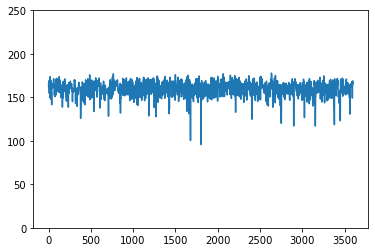

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(T[:init_size])
ax.set_ylim(0, 250)

In [20]:
np.seterr(all="raise")

stepX, stepY = 6, 20

detector = create_detector(init_size, mean_changepoint_distance)

end = 20000#T.size
rec_probs = 3*mean_changepoint_distance
growth_matrix = np.zeros(((end - init_size) // stepX, rec_probs), dtype=float)
predictive_mean = np.zeros((end - init_size) // stepX, dtype=float)
predictive_std = np.zeros((end - init_size) // stepX, dtype=float)

win_size = 250
win_mean = np.zeros((end - init_size) // stepX, dtype=float)
win_std = np.zeros((end - init_size) // stepX, dtype=float)

cp = set([0])
for i, (x, v) in enumerate(zip(T[init_size:end], V[init_size:end])):    
    if i % 1000 == 0:
        print(f"{i}/{end - init_size}")
    
    #if i == 1000 - init_size:
    #    import pdb; pdb.set_trace()
    detector.update(x)
    new_cp = detector.detect(0.8, 0.1)
    if new_cp >= 0:
        #import pdb; pdb.set_trace()
        cp.add(i - new_cp)
        
    growth_probs = detector.get_growth_probabilities()
    
    l = min(growth_probs.size, rec_probs)
    if i % stepX == 0:
        growth_matrix[i // stepX, :l] = growth_probs[:l]
        predictive_mean[i // stepX] = detector.predictive_mean()
        predictive_std[i // stepX] = detector.predictive_std()
        if i > 1:
            win_mean[i // stepX] = T[max(0, i-win_size):i].mean()
            win_std[i // stepX] = T[max(0, i-win_size):i].std()

print(f"{end - init_size}/{end - init_size}")

159.91107 8.715027
0/16400
1000/16400
2000/16400
3000/16400
4000/16400
5000/16400
6000/16400
7000/16400
8000/16400
9000/16400
10000/16400
11000/16400
12000/16400
13000/16400
14000/16400
15000/16400
16000/16400


IndexError: index 2733 is out of bounds for axis 0 with size 2733

In [17]:
#cp = [0, 886, 1270, 1718, 1988, 2368, 2810, 3149, 3280, 3565, 3663, 3963, 4495, 4930, 5050, 5463]

In [22]:
%matplotlib widget

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 5), constrained_layout=True)

ax[0].plot(T[init_size:end:stepX], color="black")#, ls="", marker=".", ms=2)
#ax[0].plot(predictive_mean, color="firebrick")
#ax[0].plot(predictive_mean + predictive_std, color="firebrick", ls="--")
#ax[0].plot(predictive_mean - predictive_std, color="firebrick", ls="--")
ax[0].set_ylim(50, 200)
ax[0].vlines([c / stepX for c in cp], ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), color="blue")
ax0_twin = ax[0].twinx()
#ax0_twin.plot(growth_matrix.argmax(axis=1), color="red")
ax[0].set_ylabel("BCT05 current [uA]")

cmap = plt.get_cmap("Greys")
gmplot = growth_matrix.T.copy()
gmplot = np.log(gmplot, where=gmplot > 0, out=np.full(gmplot.shape, -np.inf))
im = ax[1].pcolormesh(gmplot[:10000:stepY, ::], cmap=cmap, vmin=-20, vmax=0)
#ax[1].plot(np.argmax(growth_matrix, axis=1) / stepY, ls="--", color="red")

cb = fig.colorbar(im, ax=ax[1])
def label_exp(x,pos):
    return "{:.0E}".format(np.exp(x))

cb.set_ticks([np.log(t) for t in [1, 0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]])
cb.formatter = ticker.FuncFormatter(label_exp)
#cb.set_ticks([0], update_ticks=True)
cb.update_ticks()
ax[1].set_ylabel("Posterior run length distribution")

#ax[2].plot(win_mean)
#ax[2].set_ylim(150, 180)
#ax[2].set_ylim(0, 20)
#ax2_twin = ax[2].twinx()
#ax[2].vlines([c // stepX for c in cp], ymin=0, ymax=1, transform=ax[2].get_xaxis_transform())

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
cpl = sorted(cp)
cpl.append(end - init_size)
segments = [(cpl[i-1], cpl[i], T[init_size+cpl[i-1]:init_size+cpl[i]]) for i in range(1, len(cpl))]

In [85]:
segments[3]

(999,
 1181,
 array([151.96667, 167.025  , 164.02   , 157.5    , 164.1    , 164.25   ,
        166.9    , 165.925  , 158.6    , 164.55   , 165.05   , 168.475  ,
        166.83333, 168.25   , 160.225  , 170.1    , 167.375  , 166.025  ,
        167.72499, 166.35   , 168.34   , 161.42499, 166.225  , 163.65001,
        163.625  , 168.42499, 160.66   , 160.15001, 172.     , 164.53333,
        167.09999, 163.     , 162.95999, 170.15   , 166.     , 159.25   ,
        150.90001, 163.93333, 164.275  , 170.575  , 162.65001, 161.175  ,
        162.475  , 170.35   , 159.38   , 163.475  , 159.825  , 156.23334,
        158.46666, 163.475  , 159.65   , 165.05   , 167.93333, 166.575  ,
        163.1    , 161.675  , 166.16   , 161.1    , 157.65   , 170.8    ,
        158.6    , 165.76668, 160.53334, 165.575  , 172.2    , 161.375  ,
        155.02501, 160.275  , 166.04001, 157.8    , 167.17499, 163.75   ,
        170.625  , 166.5    , 158.2    , 165.875  , 162.7    , 162.63333,
        160.25002, 157.73

In [90]:
%matplotlib widget

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(25, 10), constrained_layout=True)

ax[0].plot(T[init_size:end:stepX], color="black", ls="", marker=".", ms=3)
#ax[0].plot(predictive_mean, color="firebrick")
#ax[0].plot(predictive_mean + predictive_std, color="firebrick", ls="--")
#ax[0].plot(predictive_mean - predictive_std, color="firebrick", ls="--")
ax[0].set_ylim(50, 200)
ax[0].vlines([c // stepX for c in cp], ymin=0, ymax=1, transform=ax[0].get_xaxis_transform())
ax0_twin = ax[0].twinx()
#ax0_twin.plot(growth_matrix.argmax(axis=1), color="red")

for s, e, seg in segments:
    ax[0].hlines(seg.mean(), xmin=s, xmax=e, color="firebrick")
    ax[0].hlines(seg.mean()+seg.std(), xmin=s, xmax=e, color="firebrick", ls="--")
    ax[0].hlines(seg.mean()-seg.std(), xmin=s, xmax=e, color="firebrick", ls="--")

cmap = plt.get_cmap("Greys")
gmplot = growth_matrix.T.copy()
gmplot = np.log(gmplot, where=gmplot > 0, out=np.full(gmplot.shape, -np.inf))
im = ax[1].pcolormesh(gmplot[:1000:stepY, ::], cmap=cmap, vmin=-20, vmax=0)

cb = fig.colorbar(im, ax=ax[1])
def label_exp(x,pos):
    return "{:.0E}".format(np.exp(x))

cb.set_ticks([np.log(t) for t in [1, 0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]])
cb.formatter = ticker.FuncFormatter(label_exp)
#cb.set_ticks([0], update_ticks=True)
cb.update_ticks()

#ax[2].plot(win_mean)
#ax[2].set_ylim(150, 180)
#ax[2].set_ylim(0, 20)
#ax2_twin = ax[2].twinx()
#ax[2].vlines([c // stepX for c in cp], ymin=0, ymax=1, transform=ax[2].get_xaxis_transform())

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

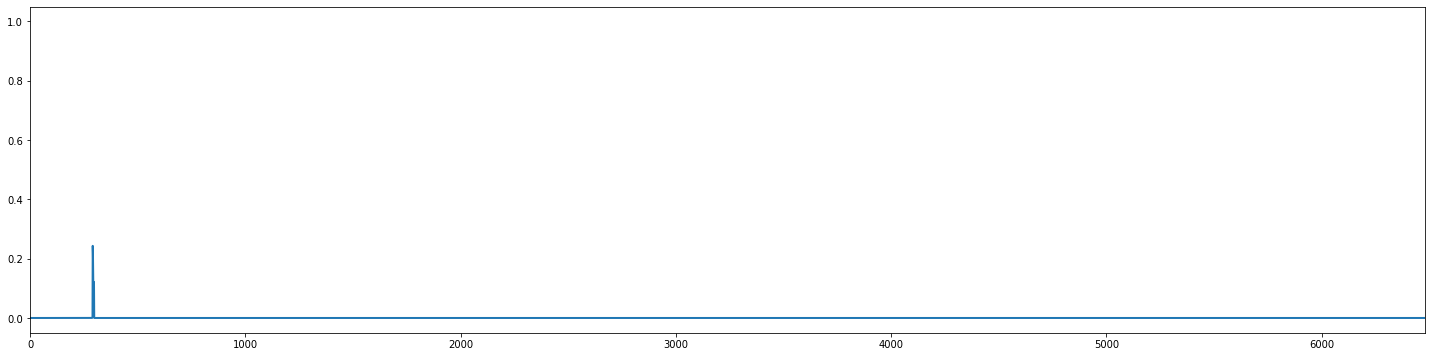

In [46]:
%matplotlib inline

import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, figsize=(25,6))
ax.set_xlim((0, growth_matrix.shape[1]))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    y = growth_matrix[i+850:]
    x = np.arange(y.size)
    line.set_data(x, y)
    print(i)
    return line,
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=1, blit=True)
anim

In [40]:
import scipy.stats as stats

np.seterr(all='raise')
stats.t.pdf(x=100, df=1000, loc=100, scale=1)

0.39884255731370694